In [2]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import torch


datagen = ImageDataGenerator(rescale=1./255)
data_generator = datagen.flow_from_directory(
    'C:\\Users\\walter\\OneDrive\\桌面\\收集\\大學nn專題\\nn實作\\阿茲海默症預測\\archive\\Dataset',
    target_size=(128, 128),#保持
    batch_size=32,
    class_mode='binary',
    shuffle=True)

# Split the data into training and testing sets
data, labels = next(data_generator)
for _ in range(len(data_generator) - 1):
    imgs, lbls = next(data_generator)
    data = np.append(data, imgs, axis=0)
    labels = np.append(labels, lbls, axis=0)

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
train_data = torch.tensor(train_data, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_data = torch.tensor(test_data, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.long)
train_data = train_data.permute(0, 3, 1, 2)  # Change data shape from (batch, height, width, channels) to (batch, channels, height, width)
test_data = test_data.permute(0, 3, 1, 2)  # Change data shape from (batch, height, width, channels) to (batch, channels, height, width)

# 獲取所有唯一的label
unique_labels = torch.unique(test_labels)

# 創建一個字典來保存分類後的數據
grouped_test_data = {label.item(): [] for label in unique_labels}

# 遍歷所有label，將對應的data加入字典中的相應列表
for label in unique_labels:
    grouped_test_data[label.item()] = test_data[test_labels == label]
    print(f"Label {label.item()}: {grouped_test_data[label.item()].size()}")
label_to_name = {  
    0: 'Non_Demented',  
    1: 'Very_Mild_Demented',  
    2: 'Mild_Demented',  
    3: 'Moderate_Demented'  
}

# grouped_data 現在包含了分類後的數據

Found 6400 images belonging to 4 classes.
Label 0: torch.Size([172, 3, 128, 128])
Label 1: torch.Size([13, 3, 128, 128])
Label 2: torch.Size([640, 3, 128, 128])
Label 3: torch.Size([455, 3, 128, 128])


training on  cuda
weights tensor([  1.0807, 132.3884,   0.3494,   0.4587], device='cuda:0')
epoch  1 ,loss  1.3242133185267448 , train acc 0.3921875
label Non_Demented mistake 1.0
label Very_Mild_Demented mistake 0.0
label Mild_Demented mistake 0.9890625
label Moderate_Demented mistake 1.0
time 11.681290864944458 sec net par
epoch  2 ,loss  1.2421535570174456 , train acc 0.387109375
label Non_Demented mistake 1.0
label Very_Mild_Demented mistake 0.0
label Mild_Demented mistake 1.0
label Moderate_Demented mistake 1.0
time 11.681506633758545 sec net par
epoch  3 ,loss  1.2275745100341737 , train acc 0.42734375
label Non_Demented mistake 1.0
label Very_Mild_Demented mistake 1.0
Epoch    10: reducing learning rate of group 0 to 9.9000e-04.
label Mild_Demented mistake 0.0
label Moderate_Demented mistake 1.0
time 11.740453243255615 sec net par
epoch  4 ,loss  1.2334718382917345 , train acc 0.4240234375
label Non_Demented mistake 0.9534883720930233
label Very_Mild_Demented mistake 0.0
label M

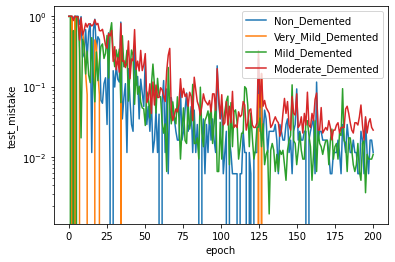

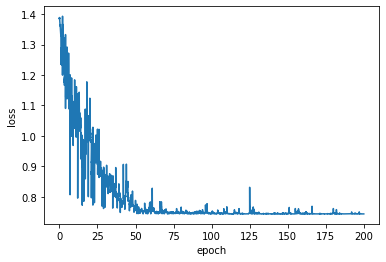

In [10]:
from torch import nn, optim
from torch.nn import init
import time
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau


class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, strider=1, use_1x1conv=False):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strider)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strider) if use_1x1conv else None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.bn3 = nn.BatchNorm2d(num_channels) if use_1x1conv else None

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        if self.conv3:
            x = self.bn3(self.conv3(x))
        y += x
        return F.relu(y)

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.res = nn.Sequential(
            *self.resnet_block(64, 64, 2, first_block=True),
            *self.resnet_block(64, 128, 2),
            *self.resnet_block(128, 256, 2),
            *self.resnet_block(256, 512, 2)
        )
        self.ft = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 4),
            nn.Sigmoid()
        )

    def resnet_block(self, input_channels, num_channels, num_residuals, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(input_channels, num_channels, strider=2, use_1x1conv=True))
            else:
                blk.append(Residual(input_channels, num_channels, strider=1))
            input_channels = num_channels
        return blk

    def forward(self, img):
        y = self.conv(img)
        y = self.res(y)
        #print("Conv output shape: ", y.shape)  # 打印卷積層輸出的形狀

        y = self.ft(y)
        return y

def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    for x, y in data_iter:
        if isinstance(net, torch.nn.Module):
            net.eval()
            x = x.to(device)
            y = y.to(device)
            acc_sum += (net(x).argmax(dim=1) == y).float().sum().cpu().item()
            net.train()
        else:
            if ('is_training' in net.__code__.co_varnames):
                acc_sum += (net(x, is_training=False).argmax(dim=1) == y).float().sum().cpu().item()
            else:
                acc_sum += (net(x).argmax(dim=1) == y).float().sum().cpu().item()
        n += y.shape[0]
    return acc_sum / n

def train(net, train_data, train_labels, test_data, test_labels, batch_size, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    mistake_dict = {name: [] for name in label_to_name.values()}
    ls=[]

# 學習率調度器
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=4, factor=0.99, verbose=True)


    a=1/grouped_test_data[0].size(0)
    b=1/grouped_test_data[1].size(0)
    c=1/grouped_test_data[2].size(0)
    d=1/grouped_test_data[3].size(0)
    weights = torch.tensor([a/a+b+c+d, 10*b/a+b+c+d, c/a+b+c+d,d/a+b+c+d]).to('cuda')   # 這裡的數字可以根據需要調整
    print("weights",weights)

    loss = torch.nn.CrossEntropyLoss(weight=weights)
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, batch_count = 0.0, 0.0, 0, 0
        start = time.time()
        dataset = torch.utils.data.TensorDataset(train_data, train_labels)
        train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

        for data, labels in train_iter:
            data = data.to(device)
            labels = labels.to(device)

            y_hat = net(data)
            l = loss(y_hat, labels)
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            

            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().cpu().item()

            n += labels.shape[0]
            batch_count += 1
            ls.append(train_l_sum/batch_count)

            '''
            # 打印每个batch后的梯度信息
            for name, param in net.named_parameters():
                if param.grad is not None:
                    print(f'{name} grad: {param.grad.mean()}')
            '''

        print('epoch ',epoch+1,',loss ',train_l_sum/batch_count,', train acc',train_acc_sum/n)
        # 遍歷每個label
        for label in grouped_test_data.keys():
            # 獲取對應的 data 和 label
            data = grouped_test_data[label]
            labels = torch.tensor([label] * len(data), dtype=torch.long)  # 為每個樣本生成相應的 label

            # 創建 TensorDataset 和 DataLoader
            dataset = TensorDataset(data, labels)
            data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

            # 計算該label的準確度
            test_acc = evaluate_accuracy(data_loader, net)
            # 使用label_to_name將label轉換為名稱，並將test_acc儲存到字典中
            name = label_to_name[label]
            mistake_dict[name].append(1-test_acc)
            print('label',name,"mistake",1-test_acc)
            #學習率
            scheduler.step(train_acc_sum/n)
        print('time',time.time()-start,'sec','net par')
    x=np.linspace(0,num_epochs,num=num_epochs)
    for label in grouped_test_data.keys():
        name = label_to_name[label]  # 将label转换为对应的名称
        plt.plot(x, mistake_dict[name], label=name)    
    plt.xlabel('epoch')
    plt.ylabel('test_mistake')
    plt.yscale('log')          # log y-axis
    plt.legend()
    plt.show()

    x_2=np.linspace(0,num_epochs,len(ls))
    plt.plot(x_2,ls)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

lr, num_epochs = 0.01, 200
torch.cuda.empty_cache()

net = ResNet()
for params in net.parameters():
    init.normal_(params, mean=0, std=0.01)

toptimizer = optim.Adam(
    net.parameters(),
    lr=0.001
)

train(net, train_data=train_data, train_labels=train_labels, test_data=test_data, test_labels=test_labels, batch_size=40, optimizer=toptimizer, device='cuda', num_epochs=num_epochs)
torch.cuda.empty_cache()


In [ ]:
torch.cuda.set_per_process_memory_fraction(0.9)  # 例如，設定為最多使用 90% 的顯存
torch.backends.cudnn.benchmark = True  # 啟用 cudnn 的最佳化
torch.cuda.empty_cache()
